In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import IsolationForest, GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data/time_domain_features_holter.csv')
y = df['died'].values
X = df.drop(["ID", "died"], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
X.shape

(176, 64)

In [3]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train).astype(np.float32)
class_weights = dict(enumerate(class_weights))
sample_weights = np.where(y_train == 1, class_weights[1], class_weights[0])
class_weights

{0: np.float32(0.75268817), 1: np.float32(1.4893616)}

## Utils

In [4]:
from importlib import reload
import utils

reload(utils)

from utils import (
    preprocess,
    find_best_fold,
    calculate_metrics,
    plot_confusion_matrix,
    display_kfold_scores,
    apply_grid_search,
    extract_params_and_k,
    get_kfold_results,
    gmean_scorer,
    CorrelationFeatureReducer
)

from sklearn.decomposition import PCA

## Constants

In [5]:
MODEL_PREFIX = "clf"
K_KEY = "select__k"
REDUCTION_TYPE = "kbest"

SELECTOR_MAP = {
    "kbest": SelectKBest(f_classif),
    "corr": CorrelationFeatureReducer(),
    "pca": PCA(),
}

SELECTOR = SELECTOR_MAP[REDUCTION_TYPE]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Isolation Forest

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SELECTOR),
    ('clf', IsolationForest(random_state=42, n_jobs=-1))
])

param_grid = {
    'select__k': [10, 20, 30, 40, 50, X.shape[-1]],
    'clf__n_estimators': [50, 100, 200, 300],
    'clf__max_samples': [93, 64, 32],
    'clf__contamination': [0.05, 0.1, 0.2, 0.3],
    'clf__max_features': [0.2, 0.4, 0.6, 0.8, 1.0]
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring=gmean_scorer
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

In [ ]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)

model = IsolationForest(random_state=42, n_jobs=-1, **best_params)
model.fit(X_train_, y_train)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test, y_pred, display=True)

In [ ]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix Isolation Forest')

In [ ]:
metrics = get_kfold_results(
    model=IsolationForest(random_state=42, n_jobs=-1, **best_params),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
)

display_kfold_scores(metrics)

In [ ]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="geometric_mean"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = IsolationForest(random_state=42, n_jobs=-1, **best_params)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

In [ ]:
plot_confusion_matrix(y_test_, y_pred, title=f'Confusion Matrix Isolation Forest (Fold {idx_best_fold + 1})')

## Random Forest

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SELECTOR),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'select__k': [10, 20, 30, 40, 50, X.shape[-1]],
    'clf__n_estimators': [50, 100, 200, 300],
    'clf__max_features': [0.2, 0.4, 0.6, 0.8, 1.0],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__bootstrap': [True, False],
    'clf__criterion': ['gini', 'entropy'],
    'clf__class_weight': [None, 'balanced', class_weights],
    'clf__oob_score': [True, False]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=gmean_scorer,
    cv=skf,
    # n_jobs=-1,
    verbose=1
)

grid_search.fit(X, y)

print("Best params:", grid_search.best_params_)
print("Best score (G-Mean):", grid_search.best_score_)

best_params = {k.split('__')[-1]: v for k, v in grid_search.best_params_.items() if k.startswith('clf')}
best_k = grid_search.best_params_['select__k']

In [ ]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)

model = RandomForestClassifier(random_state=42, **best_params)
model.fit(X_train_, y_train)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test, y_pred, display=True)

In [ ]:
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix Random Forest')

In [ ]:
metrics = get_kfold_results(
    model=RandomForestClassifier(random_state=42, **best_params),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
)

display_kfold_scores(metrics)

In [ ]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="geometric_mean"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = RandomForestClassifier(random_state=42, **best_params)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

In [ ]:
plot_confusion_matrix(y_test_, y_pred, title=f'Confusion Matrix Random Forest (Fold {idx_best_fold + 1})')

## XGBoost

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SELECTOR),
    ('clf', XGBClassifier(random_state=42))
])

param_grid = {
    'select__k': [10, 20, 30, 40, 50, X.shape[-1]],
    'clf__n_estimators': [20, 50, 100, 200, 300],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__max_depth': [2, 3, 5, 10],
    'clf__min_child_weight': [1, 2, 5, 7, 9],
    'clf__subsample': [0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.4, 0.6, 0.8, 0.9, 1.0],
}

params = apply_grid_search(
    X_train, y_train, 
    estimator=pipeline, param_grid=param_grid, 
    scoring=gmean_scorer,
    # TODO: test with and without
    fit_params={'clf__sample_weight': sample_weights}
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

In [7]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)

model = XGBClassifier(random_state=42, **best_params)
model.fit(X_train_, y_train, sample_weight=sample_weights)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 80.56
Precision: 72.73
Recall: 66.67
Specificity: 87.50
F1 Score: 69.57
Geometric Mean: 76.38


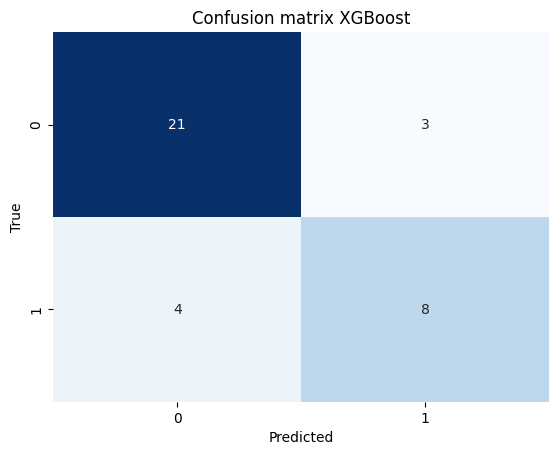

In [8]:
plot_confusion_matrix(y_test, y_pred, 'Confusion matrix XGBoost')

In [9]:
metrics = get_kfold_results(
    model=XGBClassifier(random_state=42, **best_params),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
    sample_weights=sample_weights
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 86.43 ± 7.63
Precision: 76.87 ± 15.91
Recall: 93.56 ± 5.28
Specificity: 82.87 ± 13.09
F1 Score: 83.13 ± 8.25
Geometric Mean: 87.58 ± 5.42


In [ ]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="geometric_mean"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = XGBClassifier(random_state=42, **best_params)
model.fit(X_train_, y_train_, sample_weight=sample_weights)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

In [ ]:
plot_confusion_matrix(y_test_, y_pred, title=f'Confusion Matrix XGBoost (Fold {idx_best_fold + 1})')